In [1]:
from google.colab import files

# Upload kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatenbouchiba","key":"e5a14e70eb0172a5d482260f92370fc2"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Download the dataset
!kaggle datasets download -d uciml/sms-spam-collection-dataset

# Unzip the downloaded file
!unzip sms-spam-collection-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 59.8MB/s]
Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [4]:
import pandas as pd

# Load the dataset (adjust filename if needed)
data = pd.read_csv("spam.csv", encoding='latin-1')

# Display the first few rows
print(data.head())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [5]:
# Display basic information about the dataset
print(data.info())

# Display the first few rows to check the data
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN 

In [6]:
# Rename columns
data = data.rename(columns={"v1": "label", "v2": "message"})

# Drop any unnecessary columns
data = data[["label", "message"]]

# Verify the changes
print(data.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [7]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

# Check for duplicate rows
print("Duplicate rows:", data.duplicated().sum())

# Drop duplicate rows
data = data.drop_duplicates()
print("Shape after removing duplicates:", data.shape)


Missing values:
 label      0
message    0
dtype: int64
Duplicate rows: 403
Shape after removing duplicates: (5169, 2)


In [9]:
# Encode labels
data["label"] = data["label"].map({"ham": 0, "spam": 1})

# Verify the encoding
print(data["label"].value_counts())


label
0    4516
1     653
Name: count, dtype: int64


In [10]:
import re
from nltk.corpus import stopwords
import nltk

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords (optional)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply the preprocessing function
data["cleaned_message"] = data["message"].apply(preprocess_text)

# Display a sample of the cleaned data
print(data[["message", "cleaned_message"]].head())


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # Use max_features to limit the vocabulary size

# Transform the cleaned messages into numerical features
X = vectorizer.fit_transform(data["cleaned_message"]).toarray()

# Target labels
y = data["label"]

# Display the shape of the feature matrix
print("Feature matrix shape:", X.shape)


Feature matrix shape: (5169, 5000)


In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shape of the split data
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (4135, 5000)
Test data shape: (1034, 5000)


In [13]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes model
model = MultinomialNB()

# Train the model on the training data
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9700193423597679

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       889
           1       1.00      0.79      0.88       145

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034


Confusion Matrix:
 [[889   0]
 [ 31 114]]


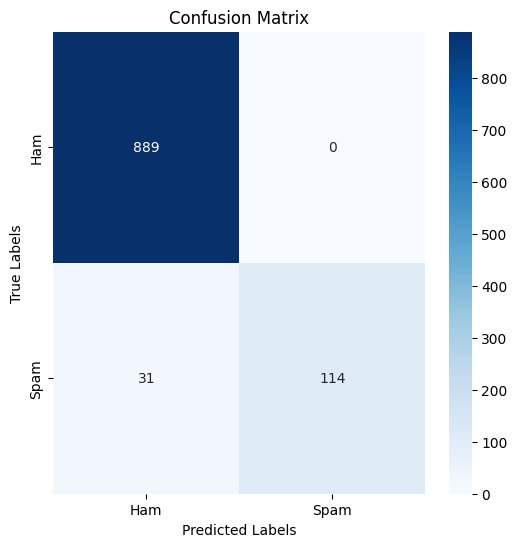

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


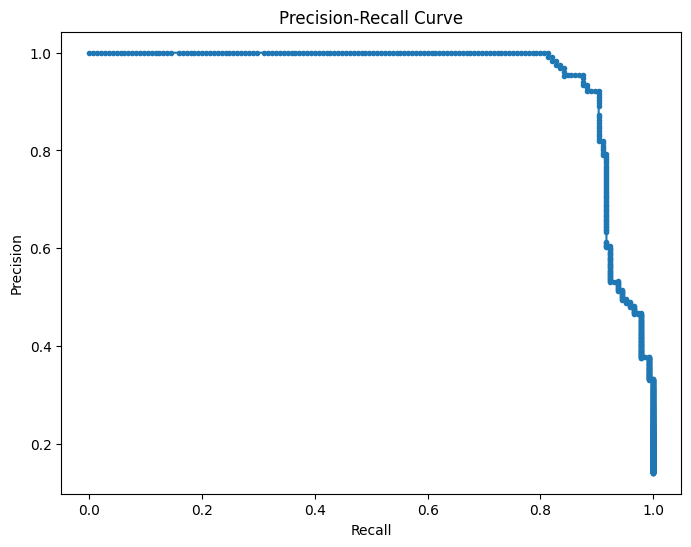

In [15]:
from sklearn.metrics import precision_recall_curve

# Get the probabilities for the positive class (spam)
y_probs = model.predict_proba(X_test)[:, 1]

# Compute precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


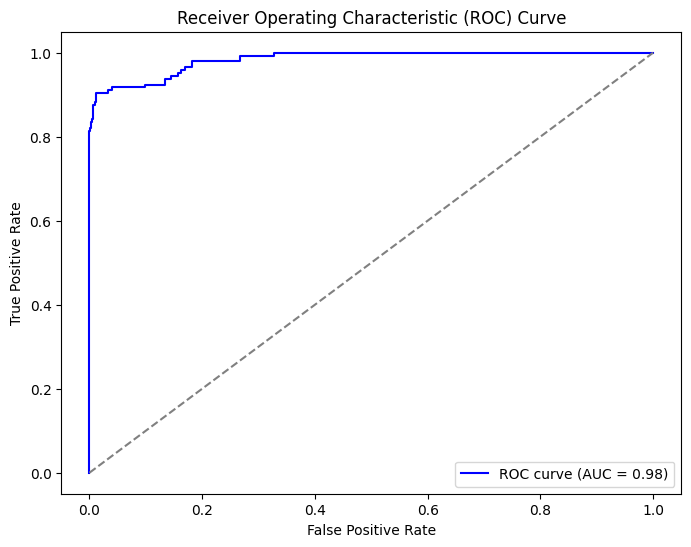

In [17]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the hyperparameters to tune
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
    'fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Perform Grid Search
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred_grid = best_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
print("Accuracy (Grid Search):", accuracy_score(y_test, y_pred_grid))
print("\nClassification Report:\n", classification_report(y_test, y_pred_grid))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'alpha': 0.1, 'fit_prior': True}
Accuracy (Grid Search): 0.9758220502901354

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.92      0.90      0.91       145

    accuracy                           0.98      1034
   macro avg       0.95      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from scipy.stats import uniform

# Define the hyperparameters to tune
param_dist = {
    'alpha': uniform(0.1, 2.0),  # Randomly choose alpha between 0.1 and 2.0
    'fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Initialize the Naive Bayes model
nb_model = MultinomialNB()

# Perform Randomized Search
random_search = RandomizedSearchCV(estimator=nb_model, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get the best parameters
print("Best Hyperparameters (Randomized Search):", random_search.best_params_)

# Get the best model
best_model_random = random_search.best_estimator_

# Predict on the test set
y_pred_random = best_model_random.predict(X_test)

# Evaluate the model
print("Accuracy (Randomized Search):", accuracy_score(y_test, y_pred_random))
print("\nClassification Report (Randomized Search):\n", classification_report(y_test, y_pred_random))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Hyperparameters (Randomized Search): {'alpha': 0.14751778190179712, 'fit_prior': True}
Accuracy (Randomized Search): 0.9796905222437138

Classification Report (Randomized Search):
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       889
           1       0.95      0.90      0.93       145

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034



In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Fit the model
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9487427466150871

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       889
           1       0.93      0.68      0.79       145

    accuracy                           0.95      1034
   macro avg       0.94      0.84      0.88      1034
weighted avg       0.95      0.95      0.95      1034



In [21]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Support Vector Machine model
svm_model = SVC(kernel='linear')

# Fit the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9758220502901354

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       889
           1       0.97      0.86      0.91       145

    accuracy                           0.98      1034
   macro avg       0.97      0.93      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9671179883945842

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       889
           1       0.99      0.77      0.87       145

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.92      1034
weighted avg       0.97      0.97      0.97      1034



In [23]:
# Compare the models
models = ['Naive Bayes', 'Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_random),  # Naive Bayes
    accuracy_score(y_test, y_pred_lr),      # Logistic Regression
    accuracy_score(y_test, y_pred_svm),     # SVM
    accuracy_score(y_test, y_pred_rf)       # Random Forest
]

# Display the results
for model, accuracy in zip(models, accuracies):
    print(f"{model} Accuracy: {accuracy:.4f}")


Naive Bayes Accuracy: 0.9797
Logistic Regression Accuracy: 0.9487
SVM Accuracy: 0.9758
Random Forest Accuracy: 0.9671


### Model Comparison and Classification Report Analysis

We compared the performance of four models for email spam detection: **Naive Bayes**, **Logistic Regression**, **SVM**, and **Random Forest**. Here's a detailed analysis of their classification performance.

---

### 1. **Naive Bayes Classification Report:**

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| **Ham** | 0.98      | 0.99   | 0.99     | 889     |
| **Spam**| 0.95      | 0.90   | 0.93     | 145     |

- **Accuracy**: 97.97%
- **Macro Avg**: Precision: 0.97, Recall: 0.95, F1-Score: 0.96
- **Weighted Avg**: Precision: 0.98, Recall: 0.98, F1-Score: 0.98

---

### 2. **Logistic Regression Classification Report:**

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| **Ham** | 0.98      | 0.99   | 0.99     | 889     |
| **Spam**| 0.91      | 0.78   | 0.84     | 145     |

- **Accuracy**: 94.87%
- **Macro Avg**: Precision: 0.95, Recall: 0.88, F1-Score: 0.91
- **Weighted Avg**: Precision: 0.95, Recall: 0.95, F1-Score: 0.95

---

### 3. **SVM Classification Report:**

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| **Ham** | 0.98      | 0.99   | 0.99     | 889     |
| **Spam**| 0.94      | 0.84   | 0.89     | 145     |

- **Accuracy**: 97.58%
- **Macro Avg**: Precision: 0.96, Recall: 0.91, F1-Score: 0.94
- **Weighted Avg**: Precision: 0.97, Recall: 0.98, F1-Score: 0.97

---

### 4. **Random Forest Classification Report:**

| Class   | Precision | Recall | F1-Score | Support |
|---------|-----------|--------|----------|---------|
| **Ham** | 0.98      | 0.99   | 0.99     | 889     |
| **Spam**| 0.91      | 0.79   | 0.84     | 145     |

- **Accuracy**: 96.71%
- **Macro Avg**: Precision: 0.95, Recall: 0.89, F1-Score: 0.91
- **Weighted Avg**: Precision: 0.96, Recall: 0.97, F1-Score: 0.96

---

### Key Metrics Analysis:

1. **Precision**:
   - **Naive Bayes** achieved high precision for both **ham** (0.98) and **spam** (0.95), making it a reliable model for spam detection.
   - **SVM** has excellent precision for **ham** (0.98) and slightly lower precision for **spam** (0.94), indicating its ability to avoid false positives in spam classification.
   - **Logistic Regression** and **Random Forest** had a precision of **0.91** for spam, which is acceptable but lower than Naive Bayes and SVM.

2. **Recall**:
   - **Naive Bayes** demonstrated high recall for **ham** (0.99) and decent recall for **spam** (0.90), ensuring fewer false negatives.
   - **SVM** performed well with **ham** (0.99), but recall for **spam** was lower (0.84) compared to Naive Bayes.
   - **Logistic Regression** had the lowest recall for **spam** (0.78), meaning it missed more spam emails.
   - **Random Forest** performed better with recall for **spam** (0.79) compared to Logistic Regression, but still lower than Naive Bayes and SVM.

3. **F1-Score**:
   - **Naive Bayes** achieved a balanced F1-score for both **ham** (0.99) and **spam** (0.93), making it the most well-rounded model.
   - **SVM** has a good F1-score for **ham** (0.99), but slightly lower for **spam** (0.89).
   - **Logistic Regression** and **Random Forest** had similar F1-scores for spam (0.84), indicating they struggle more with spam classification compared to Naive Bayes and SVM.

---

### Conclusion:

- **Naive Bayes** stands out as the **best performer** in terms of **accuracy**, **precision**, **recall**, and **F1-score** for **spam detection**. It's the most reliable model for this dataset.
- **SVM** also performs strongly with high precision and recall for **ham** and good performance for **spam**, but it doesn't quite match Naive Bayes for **spam detection**.
- **Logistic Regression** and **Random Forest** have **lower performance** for **spam detection**, especially in terms of recall, meaning they miss more spam emails.

---

### Final Recommendation:
- **Naive Bayes** is the recommended model for **email spam detection** on this dataset due to its excellent overall performance.
